In [1]:
# import libraries
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from sklearn.metrics import mean_squared_error, classification_report
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir("res")

In [3]:
# load dataset
df = pd.read_csv("Hospital_Inpatient_Discharges__SPARCS_De-Identified___2021_20231012.csv")
# https://www.kaggle.com/datasets/bhautikmangukiya12/hospital-inpatient-discharges-dataset 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101588 entries, 0 to 2101587
Data columns (total 33 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Hospital Service Area                object 
 1   Hospital County                      object 
 2   Operating Certificate Number         float64
 3   Permanent Facility Id                float64
 4   Facility Name                        object 
 5   Age Group                            object 
 6   Zip Code - 3 digits                  object 
 7   Gender                               object 
 8   Race                                 object 
 9   Ethnicity                            object 
 10  Length of Stay                       object 
 11  Type of Admission                    object 
 12  Patient Disposition                  object 
 13  Discharge Year                       int64  
 14  CCSR Diagnosis Code                  object 
 15  CCSR Diagnosis Description      

In [5]:
descriptions = ['CCSR Diagnosis Description', 'CCSR Procedure Description',
                'APR DRG Description','APR MDC Description',
                'APR Severity of Illness Description']


df.drop(descriptions,axis=1,inplace=True)

In [6]:
df['Length of Stay'] =df['Length of Stay'].replace('120 +',120)
df['Length of Stay'] = pd.to_numeric(df['Length of Stay'])
len_of_stay = df['Length of Stay']
len_of_stay


0          27
1           4
2           2
3           5
4           3
           ..
2101583     1
2101584    13
2101585     7
2101586     2
2101587     7
Name: Length of Stay, Length: 2101588, dtype: int64

In [7]:
df.isnull().sum()

Hospital Service Area                 10642
Hospital County                       10642
Operating Certificate Number          12091
Permanent Facility Id                 10642
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                   45062
Gender                                    0
Race                                      0
Ethnicity                                 0
Length of Stay                            0
Type of Admission                         0
Patient Disposition                       0
Discharge Year                            0
CCSR Diagnosis Code                    1634
CCSR Procedure Code                  576021
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                  2550
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2              

In [8]:
for col in df.columns:
    num_unique = len(df[col].unique())
    print(f"{col} num unique : {num_unique}")

Hospital Service Area num unique : 9
Hospital County num unique : 58
Operating Certificate Number num unique : 169
Permanent Facility Id num unique : 206
Facility Name num unique : 205
Age Group num unique : 5
Zip Code - 3 digits num unique : 51
Gender num unique : 3
Race num unique : 4
Ethnicity num unique : 4
Length of Stay num unique : 120
Type of Admission num unique : 6
Patient Disposition num unique : 19
Discharge Year num unique : 1
CCSR Diagnosis Code num unique : 478
CCSR Procedure Code num unique : 321
APR DRG Code num unique : 334
APR MDC Code num unique : 26
APR Severity of Illness Code num unique : 5
APR Risk of Mortality num unique : 5
APR Medical Surgical Description num unique : 3
Payment Typology 1 num unique : 9
Payment Typology 2 num unique : 10
Payment Typology 3 num unique : 10
Birth Weight num unique : 131
Emergency Department Indicator num unique : 2
Total Charges num unique : 1818969
Total Costs num unique : 1549652


In [9]:
df = df[df['Patient Disposition'] != 'Expired']

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Medicare'),
  Text(1, 0, 'Private Health Insurance'),
  Text(2, 0, 'Medicaid'),
  Text(3, 0, 'Blue Cross/Blue Shield'),
  Text(4, 0, 'Self-Pay'),
  Text(5, 0, 'Miscellaneous/Other'),
  Text(6, 0, 'Managed Care, Unspecified'),
  Text(7, 0, 'Department of Corrections'),
  Text(8, 0, 'Federal/State/Local/VA')])

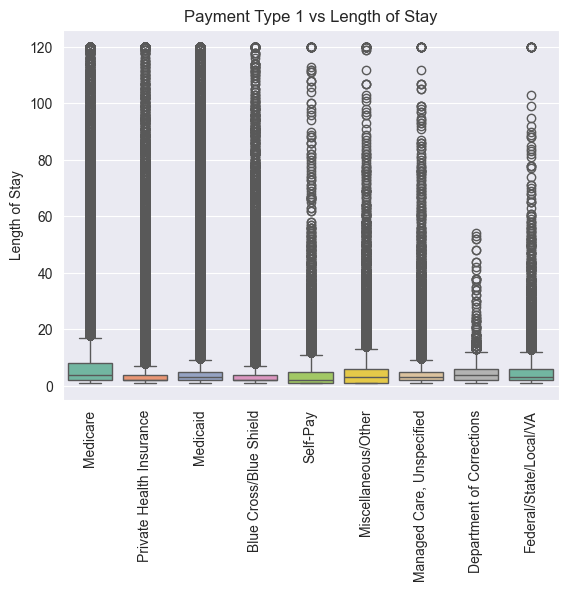

In [10]:
# EDA

#len_of_stay <-> age/type of admission/payment typology 1/


sns.boxplot(x = 'Payment Typology 1', y = 'Length of Stay', data = df, palette='Set2')
plt.title("Payment Type 1 vs Length of Stay")
plt.xlabel("")
plt.xticks(rotation=90)

([0, 1, 2, 3, 4],
 [Text(0, 0, '70 or Older'),
  Text(1, 0, '50 to 69'),
  Text(2, 0, '30 to 49'),
  Text(3, 0, '18 to 29'),
  Text(4, 0, '0 to 17')])

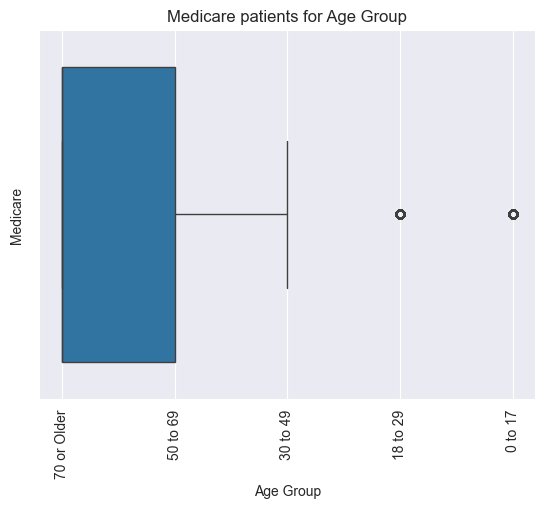

In [11]:
age_order = ['0 to 17','18 to 29','30 to 49','50 to 69','70 or Older']

sns.boxplot(x = 'Age Group', data = df[df['Payment Typology 1'] == 'Medicare'])
plt.title("Medicare patients for Age Group")
plt.xlabel("Age Group")
plt.ylabel("Medicare")
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Emergency'),
  Text(1, 0, 'Newborn'),
  Text(2, 0, 'Elective'),
  Text(3, 0, 'Urgent'),
  Text(4, 0, 'Trauma'),
  Text(5, 0, 'Not Available')])

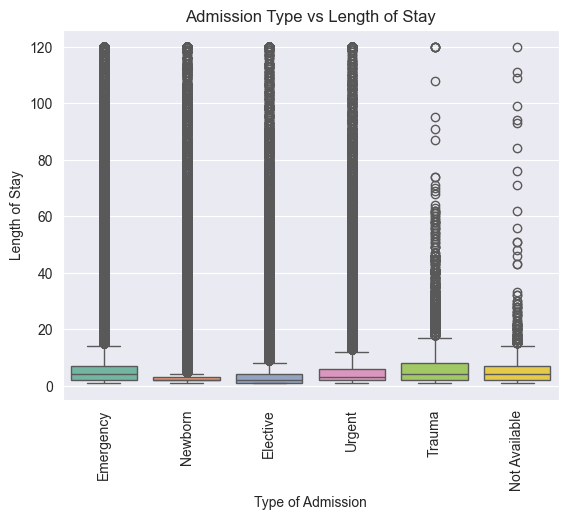

In [12]:
sns.boxplot(x = 'Type of Admission', y = 'Length of Stay', data = df, palette='Set2')
plt.title("Admission Type vs Length of Stay")
plt.xticks(rotation=90)

[(0.0, 25.0)]

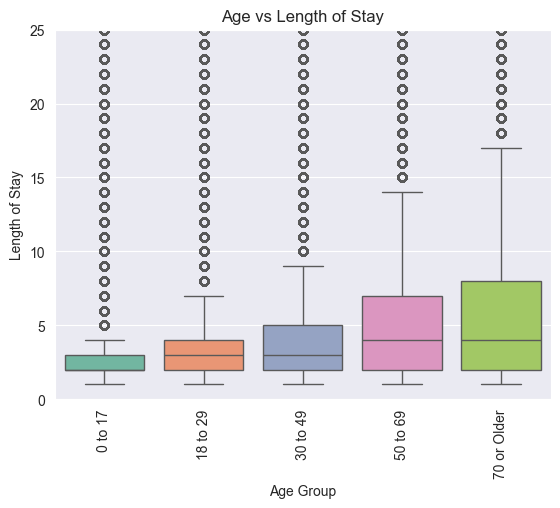

In [13]:
f, ax = plt.subplots()
sns.boxplot(x = 'Age Group', y = 'Length of Stay', data = df, palette='Set2', order = age_order)
plt.title("Age vs Length of Stay")
plt.xticks(rotation=90)
ax.set(ylim = (0,25))

In [14]:
# feature encoding - selection : label encoding
columns_with_missing_data = list()
for i,val in enumerate(df.isnull().sum()):
    if val > 100000:
        columns_with_missing_data.append(df.columns[i])

df.drop(columns_with_missing_data,axis=1,inplace=True)
columns_with_missing_data # deleted missing data columns

['CCSR Procedure Code',
 'Payment Typology 2',
 'Payment Typology 3',
 'Birth Weight']

In [15]:
df.drop(['Hospital Service Area', 'Hospital County', 'Operating Certificate Number', 'Facility Name','Zip Code - 3 digits', 'Discharge Year','Total Charges', 'Total Costs'],axis=1,inplace=True)

In [16]:
df['APR Risk of Mortality']

0           Extreme
1             Minor
2             Minor
3             Major
4             Minor
             ...   
2101583       Minor
2101584       Major
2101585       Minor
2101586       Minor
2101587    Moderate
Name: APR Risk of Mortality, Length: 2037764, dtype: object

In [17]:
# manual label encoding
age_group_idx = {'0 to 17' : 0,
                 '18 to 29' : 1,
                 '30 to 49' : 2,
                 '50 to 69' : 3,
                 '70 or Older' : 4} 

gender_idx = {'U' : 0 , 'F' : 1 , 'M' : 2} # undefined, female, male

risk_and_severity_idx = {np.nan : 0, 
                         'Minor' : 1,
                         'Moderate' : 2,
                         'Major' : 3,
                         'Extreme' : 4}

def manual_encode(col_name, col_dict):
    df[col_name] = df[col_name].apply(lambda x: col_dict[x])

In [18]:
manual_encode('Age Group', age_group_idx)
manual_encode('Gender', gender_idx)
manual_encode('APR Risk of Mortality', risk_and_severity_idx)


In [19]:
encoder = OrdinalEncoder()

def encode_feature(feature):
    arr2encode = np.asarray(df[feature]).reshape(-1,1)
    df[feature] = encoder.fit_transform(arr2encode)

In [20]:
encode_feature('Race')    
encode_feature("Ethnicity")
encode_feature('Type of Admission')
encode_feature('CCSR Diagnosis Code')
encode_feature('APR Medical Surgical Description')
encode_feature('Payment Typology 1')
encode_feature('Emergency Department Indicator')
encode_feature('Patient Disposition')


In [21]:
df.isna().sum()

Permanent Facility Id               10590
Age Group                               0
Gender                                  0
Race                                    0
Ethnicity                               0
Length of Stay                          0
Type of Admission                       0
Patient Disposition                     0
CCSR Diagnosis Code                  1614
APR DRG Code                            0
APR MDC Code                            0
APR Severity of Illness Code            0
APR Risk of Mortality                   0
APR Medical Surgical Description        0
Payment Typology 1                      0
Emergency Department Indicator          0
dtype: int64

In [22]:
df.dropna(subset=['Permanent Facility Id','CCSR Diagnosis Code'],inplace=True) 
# just delete the lines where data = na

In [23]:
df.head()

,Permanent Facility Id,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,Patient Disposition,CCSR Diagnosis Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Emergency Department Indicator
0,1169.0,4,2,2.0,2.0,27,1.0,7.0,154.0,137,4,3,4,0.0,5.0,1.0
1,1169.0,3,1,3.0,1.0,4,1.0,6.0,377.0,43,1,2,1,0.0,7.0,1.0
2,1168.0,1,1,2.0,2.0,2,1.0,6.0,423.0,540,14,1,1,2.0,4.0,0.0
3,3058.0,4,2,2.0,2.0,5,1.0,6.0,121.0,463,11,3,3,0.0,5.0,1.0
4,1169.0,3,1,0.0,1.0,3,1.0,6.0,380.0,58,1,2,1,0.0,5.0,1.0


In [24]:
# traint test split
X = df.drop(['Length of Stay'], axis = 1)
y = df['Length of Stay']

In [25]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# regression : train & test
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)
train_prediction = dtree.predict(X_train) # check overfitting
test_prediction = dtree.predict(X_test)

In [33]:
print("RMSE - Train : ", np.sqrt(mean_squared_error(y_train, train_prediction))) # +- 2.23
print("RMSE - Test : ", np.sqrt(mean_squared_error(y_test, test_prediction))) # +- 7.88

"""
# overfitting detected.
RMSE - Train :  2.2333729853131077 | 7-10-13
RMSE - Test :  7.887715406517475 | 2-10-18
"""

RMSE - Train :  2.2333729853131077
RMSE - Test :  7.882180547056012


In [34]:
dtree = DecisionTreeRegressor(max_depth=10, random_state=42) # handle overfitting
dtree.fit(X_train, y_train)
train_prediction = dtree.predict(X_train)
test_prediction = dtree.predict(X_test)

In [35]:
print("RMSE - Train : ", np.sqrt(mean_squared_error(y_train, train_prediction))) # +- 2.23
print("RMSE - Test : ", np.sqrt(mean_squared_error(y_test, test_prediction))) # +- 7.88

"""
after max_depth = 10, random state = 42
RMSE - Train :  4-10-16
RMSE - Test :  4-10-16

"""

RMSE - Train :  5.934390399960895
RMSE - Test :  6.0981366466164
